<a href="https://colab.research.google.com/github/Bitang-Melyen-Tanulok/Csip_Csip/blob/main/Train_final_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image
from google.colab import drive

X = []
Y = []
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DeepLearning'
spectrograms_path = os.path.join(path, 'ugyanaz?')  # Adott mappa elérési útvonala
folders = os.listdir(spectrograms_path)

for folder in folders:
    print(f"Current folder: {folder}")
    folder_path = os.path.join(spectrograms_path, folder)  # Mappa útvonal

    # Fájlok bejárása a mappában
    files = os.listdir(folder_path)

    for file in files:
        if file.endswith('.png'):  # Csak PNG fájlokat olvasunk be
            file_path = os.path.join(folder_path, file)

            # Kép betöltése
            img = image.load_img(file_path, color_mode='rgb')
            img_array = image.img_to_array(img)  # Kép tömbbé alakítása
            X.append(img_array)
            Y.append(folder)


X = np.array(X)
Y = np.array(Y)

print(f"\nX shape: {X.shape}")
print(f"Y shape: {Y.shape}")

#shuffle X and Y the same way
permutation = np.random.permutation(len(X))
X = X[permutation]
Y = Y[permutation]

test_split = 0.1
valid_split = 0.1

nb_samples = len(X)
valid_start_idx = int(nb_samples*(1-valid_split-test_split))
test_start_idx = int(nb_samples*(1-test_split))

X_train = X[:valid_start_idx]
Y_train = Y[:valid_start_idx]
X_valid = X[valid_start_idx:test_start_idx]
Y_valid = Y[valid_start_idx:test_start_idx]
X_test = X[test_start_idx:]
Y_test = Y[test_start_idx:]

Mounted at /content/drive
Current folder: blrwar1
Current folder: grenig1
Current folder: junmyn1
Current folder: pursun4
Current folder: revbul
Current folder: barswa
Current folder: jerbus2
Current folder: insowl1
Current folder: lewduc1
Current folder: plaflo1
Current folder: putbab1
Current folder: redspu1
Current folder: rewlap1
Current folder: rufbab3
Current folder: sqtbul1
Current folder: vefnut1
Current folder: categr
Current folder: forwag1
Current folder: rerswa1
Current folder: rutfly6

X shape: (1769, 128, 313, 3)
Y shape: (1769,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Since this is a multi-class classification task, I am converting labels to one-hot format:

#First, the labels need to be converted into numerical values
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_valid_encoded = le.transform(Y_valid)
Y_test_encoded = le.transform(Y_test)

#Getting number of classes
num_classes = len(le.classes_)
print(f"Class number= {num_classes}")

# Converting to one-hot encoding
Y_train= to_categorical(Y_train_encoded, num_classes)
Y_valid = to_categorical(Y_valid_encoded, num_classes)
Y_test = to_categorical(Y_test_encoded, num_classes)

Class number= 20


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#Implementing early stopping, since there is no reason for it to learn further when val_loss isn't decreasing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #If it doesn't improve for 10 epochs, it concludes
    verbose=1,
    restore_best_weights=True
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint # Importing the missing ModelCheckpoint class

checkpoint_dir = '/content/drive/MyDrive/DeepLearning/checkpoints_sample'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_train_path = os.path.join(checkpoint_dir, 'model_train_{epoch:02d}_{val_loss:.4f}.keras')
checkpoint_finetune_path = os.path.join(checkpoint_dir, 'model_finetune_{epoch:02d}_{val_loss:.4f}.keras')

#Saving the latest model at each epoch, so that if colab collapses, we don't have to start from zero
checkpoint_train = ModelCheckpoint(
    checkpoint_train_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

checkpoint_finetune = ModelCheckpoint(
    checkpoint_finetune_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

In [ ]:
import re

def return_latest_checkpoint_path(checkpoint_dir, fold_prefix):
    model_files = os.listdir(checkpoint_dir)
    # Filter files that match the fold_prefix
    model_files = [f for f in model_files if f.startswith(fold_prefix)]
    if not model_files:
        print("No checkpoint found for fold.")
        return None, 0

    # Extract epoch numbers using regex
    epoch_numbers = []
    for f in model_files:
        match = re.search(r'_(\d+)', f)  # Extract the number after fold prefix and before '_val_loss'
        if match:
            epoch_numbers.append((int(match.group(1)), f))

    # Get the latest file by epoch number
    latest_epoch, latest_file = max(epoch_numbers, key=lambda x: x[0])
    latest_model_path = os.path.join(checkpoint_dir, latest_file)

    return latest_model_path, latest_epoch

In [ ]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import load_model

# Implementing mixed precision training for faster outcomes
mixed_precision.set_global_policy('mixed_float16')

# Normalizing the data to fit EfficientNetV2B0
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)

# Setting the input shape based on the data
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# Loading the pre-trained EfficientNetV2B0 model
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

# Defining a new model
model = models.Sequential()

# Freezing the base model layers if we don't want to update them during training
base_model.trainable = False

# Adding the pre-trained model
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Selecting the best representations
# Adding additional layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))  # Adding Dropout to prevent overfitting
model.add(layers.Dense(num_classes, activation='softmax'))

# Loading saved model with the latest epoch froim 'model_train_{epoch:02d}_{val_loss:.4f}.keras'
latest_checkpoint_path, initial_epoch = return_latest_checkpoint_path(checkpoint_dir, 'model_train')
if latest_checkpoint_path:
    model = load_model(latest_checkpoint_path)
    print("Resumed training from the latest checkpoint.")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    X_train, Y_train,
    epochs=20,
    initial_epoch=initial_epoch,
    batch_size=128, # try larger throughput 128, 256, original is 64
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stopping, checkpoint_train],
    verbose=1
)

# Fine-tuning the last 10 layers
base_model.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Loading saved model with the latest epoch froim 'model_train_{epoch:02d}_{val_loss:.4f}.keras'
latest_checkpoint_path, initial_epoch = return_latest_checkpoint_path(checkpoint_dir, 'model_finetune')
if latest_checkpoint_path:
    model = load_model(latest_checkpoint_path)
    print("Resumed fine-tuning from the latest checkpoint.")
else:
    initial_epoch = 0
    print("Starting fine-tuning from scratch.")

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy']) # low learning rate

fine_tuning_history = model.fit(
    X_train, Y_train,
    epochs=5,
    initial_epoch=initial_epoch,
    batch_size=128,
    validation_data=(X_valid, Y_valid),
    callbacks=[early_stopping, checkpoint_finetune],
    verbose=1
)

# Saving the results
final_model_path = os.path.join(checkpoint_dir, f'final_model.keras')
model.save(final_model_path)

valid_loss, valid_accuracy = model.evaluate(X_valid, Y_valid)

# Summary of the final model
model.summary()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


24274472/24274472 [==============================] - 0s 0us/step
Resumed training from the latest checkpoint.
Epoch 5/20
12/12 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.6792 
Epoch 5: saving model to /content/drive/MyDrive/DeepLearning/checkpoints_sample/model_train_05_1.3348.keras
12/12 [==============================] - 141s 11s/step - loss: 1.2012 - accuracy: 0.6792 - val_loss: 1.3348 - val_accuracy: 0.5989
Epoch 6/20
12/12 [==============================] - ETA: 0s - loss: 1.0715 - accuracy: 0.6961 
Epoch 6: saving model to /content/drive/MyDrive/DeepLearning/checkpoints_sample/model_train_06_1.2337.keras
12/12 [==============================] - 128s 11s/step - loss: 1.0715 - accuracy: 0.6961 - val_loss: 1.2337 - val_accuracy: 0.6384
Epoch 7/20
12/12 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.7371 
Epoch 7: saving model to /content/drive/MyDrive/DeepLearning/checkpoints_sample/model_train_07_1.1623.keras
12/12 [============

In [ ]:
print("\nResults:")
print(f"Validation Loss: {valid_loss}")
print(f"Validation Accuracy: {valid_accuracy}")


Results:
Validation Loss: 0.751702070236206
Validation Accuracy: 0.7740113139152527


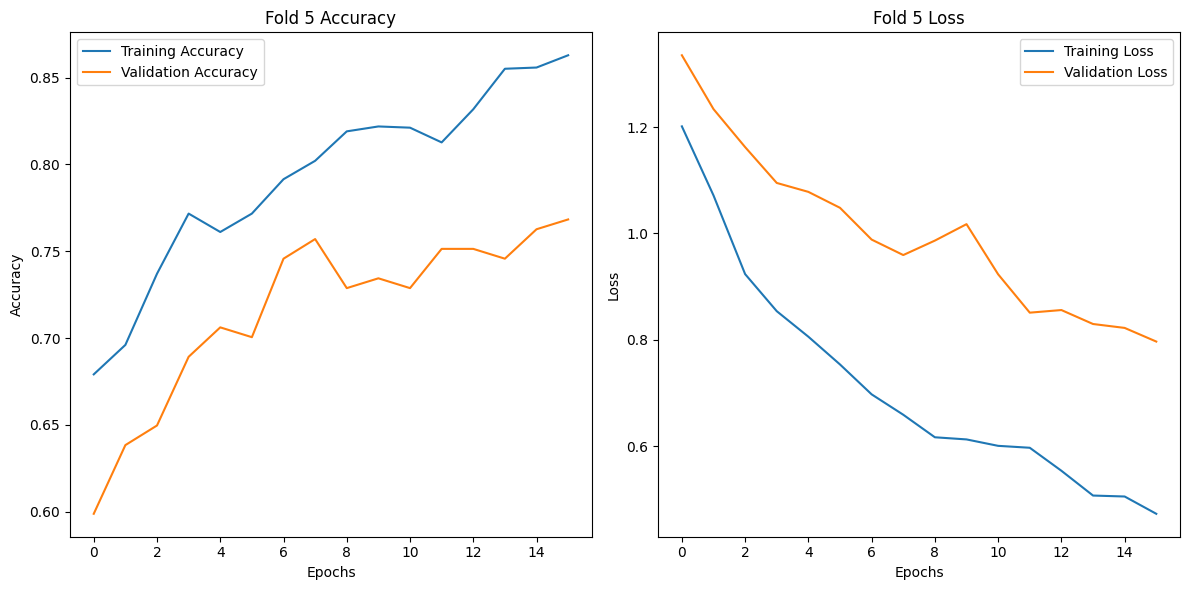

In [ ]:
import matplotlib.pyplot as plt

#Diplaying accuracy and loss on separate diagrams
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Fold {5} Accuracy') # i is replaced by 5
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Fold {5} Loss') # i is replaced by 5
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()